Before SMOTE: loan_status
1    5751
0    2249
Name: count, dtype: int64
After SMOTE: loan_status
1    5751
0    5751
Name: count, dtype: int64
✅ Balanced & tuned model saved.

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.32      0.35       562
           1       0.75      0.80      0.77      1438

    accuracy                           0.66      2000
   macro avg       0.57      0.56      0.56      2000
weighted avg       0.65      0.66      0.65      2000



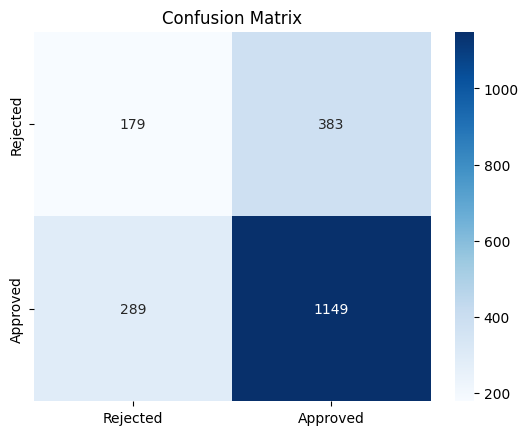

 98%|===================| 197/200 [00:33<00:00]        

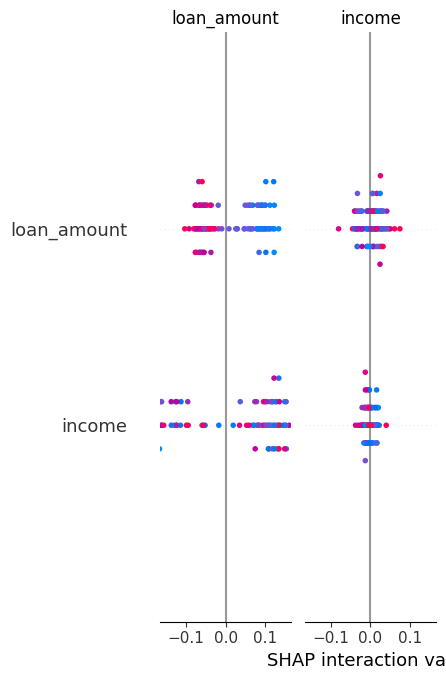


❌ Harmful factors for rejection:
                   feature  value  shap_value
11  high_consumption_flag    0.0   -0.167402
8               eco_score    2.0   -0.025982
7            credit_score  743.0   -0.009346

✅ Helpful factors for approval:
                  feature    value  shap_value
10                 is_EV      0.0    0.053685
6   loan_history_encoded      2.0    0.054635
1            loan_amount  13000.0    0.059543
✅ SHAP analysis complete. Check plots for insights.


In [ ]:
# 1️⃣ Imports
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import joblib
import shap
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:

# 2️⃣ Load and prepare data
df = pd.read_csv("../updated_midoriloan_data.csv")


In [ ]:

# Encode categorical fields
from sklearn.preprocessing import LabelEncoder
df['fuel_type_encoded'] = LabelEncoder().fit_transform(df['fuel_type'])
df['job_type_encoded'] = LabelEncoder().fit_transform(df['job_type'])
df['loan_history_encoded'] = LabelEncoder().fit_transform(df['loan_history'])


In [ ]:

# Feature engineering
df['DTI_ratio'] = df['loan_amount'] / df['income']
df['is_EV'] = (df['fuel_type'] == 'Electric').astype(int)
df['high_consumption_flag'] = (df['monthly_units'] > 500).astype(int)
df['eco_category'] = pd.cut(df['eco_score'], bins=[-1, 7, 14, 20], labels=['Low', 'Medium', 'High'])
df['eco_category_encoded'] = LabelEncoder().fit_transform(df['eco_category'])


In [ ]:

# Final features
feature_cols = [
    'income', 'loan_amount', 'monthly_units', 'vehicle_type',
    'fuel_type_encoded', 'job_type_encoded', 'loan_history_encoded',
    'credit_score', 'eco_score', 'DTI_ratio', 'is_EV',
    'high_consumption_flag', 'eco_category_encoded'
]
X = df[feature_cols]
y = df['loan_status']


In [ ]:

# 3️⃣ Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:

# 4️⃣ SMOTE balancing
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_resampled.value_counts())


In [ ]:

# 5️⃣ Tuned RandomForest
model = RandomForestClassifier(
    n_estimators=300,       # more trees for better learning
    max_depth=12,           # limit depth to prevent overfitting
    min_samples_split=5,    # require more samples to split a node
    min_samples_leaf=2,     # require more samples at leaf
    class_weight="balanced",# extra balance
    random_state=42
)
model.fit(X_resampled, y_resampled)


In [ ]:

# 6️⃣ Save model
joblib.dump(model, "loan_model.pkl")
print("✅ Balanced & tuned model saved.")


In [ ]:

# 7️⃣ Evaluate
y_pred = model.predict(X_test)
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Rejected", "Approved"],
            yticklabels=["Rejected", "Approved"])
plt.title("Confusion Matrix")
plt.show()


In [ ]:

# 8️⃣ SHAP Explainability (global)
explainer = shap.Explainer(model, X)
shap_values = explainer(X_test.sample(100, random_state=42))
shap.summary_plot(shap_values.values, X_test.sample(100, random_state=42), plot_type="bar")

# 9️⃣ SHAP for a single prediction
user_index = 5  # change as needed
class_index = 0  # 0 for Rejected, 1 for Approved

X_user = X_test.iloc[user_index]
shap_user_values = shap_values.values[user_index, :, class_index]

# Now all arrays are same length (n_features)
explanation = pd.DataFrame({
    "feature": X.columns,
    "value": X_user.values,
    "shap_value": shap_user_values
}).sort_values(by="shap_value", ascending=True)

print("\n❌ Harmful factors for rejection:\n", explanation.head(3))
print("\n✅ Helpful factors for approval:\n", explanation.tail(3))
print("✅ SHAP analysis complete. Check plots for insights.")
